In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
import random

import scipy.cluster.hierarchy as sch
from sklearn.metrics import precision_recall_fscore_support as f1_score
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
data = np.zeros((100000, 100, 1))
for i in range(data.shape[0]):
    for j in range(data.shape[2]):
        data[i, :, j] = np.random.normal((i%20 * 5), np.random.randint(1, 25), data.shape[1])

In [4]:
timesteps = 100  # Length of your sequences
input_dim = 1 
latent_dim = 16

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64)(inputs)
encoded = Dense(latent_dim)(encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=1)
# autoencoder.fit(data[2000:],data[2000:], epochs=1000, validation_data=(data[:2000],data[:2000]), callbacks=[es], batch_size=1024)

In [5]:
autoencoder = tf.keras.models.load_model("autoencoder.h5")
encoder = tf.keras.models.load_model("encoder.h5")

In [6]:
from sklearn.decomposition import FastICA, TruncatedSVD, PCA, FactorAnalysis

class Pca:
    def __init__(self, data):
        self.model = PCA(16).fit(data)
    def predict(self, data):
        return self.model.transform(data)

class FactorAnal:
    def __init__(self, data):
        self.model = FactorAnalysis(32).fit(data)
    def predict(self, data):
        return self.model.transform(data)

class ICA:
    def __init__(self, data):
        self.model = FastICA(n_components=16, random_state=12).fit(data)
    def predict(self, data):
        return self.model.transform(data)
    
pca = Pca(data.reshape((100000, 100)))

In [7]:
x = np.zeros((4, 1000))
y = x[:, 1:101]
y.shape
z = encoder.predict(y)
z.shape
from scipy.spatial import distance_matrix
distance_matrix(z, z)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [8]:
import pandas as pd
pd.__version__

'1.3.0'

In [9]:
from tqdm import tqdm
def compute_distances(sensors, encoder, window=5, plot=True):
    sensor_array = np.vstack(sensors)
    num_sensors = len(sensors)
    total_timesteps = len(sensors[0])
    truncated_timestep = timesteps
    sensor_distance_timeseries = np.zeros((total_timesteps - truncated_timestep, num_sensors, num_sensors))
    time_vec = np.arange(total_timesteps - truncated_timestep)
    for i in tqdm(range(total_timesteps - truncated_timestep)):
        truncated_timeseries = sensor_array[:, i:i+truncated_timestep]
        truncated_encodings = encoder.predict(truncated_timeseries)
        sensor_distance_timeseries[i] = distance_matrix(truncated_encodings, truncated_encodings)
        print(sensor_distance_timeseries[i][0][-1])
    if plot:
        fig, axs = plt.subplots(num_sensors, num_sensors, sharex=True, sharey=True, figsize=(16, 16))
        for i in range(num_sensors):
            for j in range(num_sensors):
                axs[i,j].plot(time_vec, pd.Series(sensor_distance_timeseries[:, i, j]).rolling(window).mean())
                axs[i,j].set_title("")
                axs[i,j].set(xlabel=f'sensor {j+1}', ylabel="Euclidean Distance")
                ax2 = axs[i,j].twinx()
                ax2.axes.yaxis.set_ticks([])
                if j == 3:
                    ax2.set_ylabel(f'sensor {i+1}')
                if i == 3 or j == 3:
                    axs[i,j].patch.set_facecolor("xkcd:light yellow")
        for ax in axs.flat:
            ax.label_outer()
    return sensor_distance_timeseries, fig

In [10]:
def dist_thresh(sensors, encodings, recon=None, dist_thres=1, sensitivity=0):
    distances = distance_matrix(encodings, encodings)
    dist_thresh = np.quantile(distances[0][1:], .7) + 0.1
    ind_anomalies = []
    if recon is not None:
        recon = recon.reshape((-1, timesteps))
        recon_loss = tf.keras.losses.mean_squared_error(recon, sensors).numpy()
        recon_thres = np.quantile(recon_loss, .7) + 1
        for i in range(len(recon_loss)):
            if recon_loss[i] > recon_thres:
                ind_anomalies.append(i)
    dist_anomalies = []
    for i in range(distances.shape[0]):
        counter = distances.shape[0] - sensitivity - 1
        for j in range(distances.shape[1]):
            if distances[i, j] >= dist_thresh:
                counter -= 1
#                 print(distances[i,j])
        if counter <= 0:
            dist_anomalies.append(i)
#     return ind_anomalies, dist_anomalies
    indx = np.array(list(set(ind_anomalies) | set(dist_anomalies)))
    out = np.zeros((len(sensors),))
    for i in indx:
        out[i] = 1
    return out

In [11]:
from numpy.lib.stride_tricks import sliding_window_view

def compute_anomalies_autoencoder(sensors, encoder, autoencoder=None, window=1, plot=True, dist_thres=1):
    sensor_array = np.vstack(sensors)
    num_sensors = len(sensors)
    total_timesteps = len(sensors[0])
    truncated_timestep = timesteps
    sensor_anomaly_timeseries = np.zeros((total_timesteps - truncated_timestep, num_sensors))
    time_vec = np.arange(total_timesteps - truncated_timestep)
    sensor_data = sliding_window_view(sensor_array, window_shape=timesteps, axis=-1).reshape(-1, truncated_timestep)
    encodings = encoder.predict(sensor_data).reshape(-1, num_sensors, latent_dim)
    recon = None
    if autoencoder is not None:
        recon = autoencoder.predict(sensor_data).reshape(-1, num_sensors, truncated_timestep)
    for i in range(total_timesteps - truncated_timestep):
        truncated_timeseries = sensor_array[:, i:i+truncated_timestep]
        enc = encodings[i]
        if recon is not None:
            rec = recon[i]
        else:
            rec = None
        sensor_anomaly_timeseries[i] = dist_thresh(truncated_timeseries, enc, rec, dist_thres=dist_thres)
    if plot:
        fig, axs = plt.subplots(num_sensors, sharex=True, sharey=True, figsize=(16, 4))
        for i in range(num_sensors):
                axs[i].plot(time_vec, sensor_anomaly_timeseries[:, i])
                axs[i].set_title("")
                axs[i].set(xlabel=f'sensor {j}')
        for ax in axs.flat:
            ax.label_outer()
    return sensor_anomaly_timeseries

In [12]:
from tqdm import tqdm
def compute_anomalies_pca(sensors, encoder, window=5, plot=True, dist_thres=20, sensitivity=0):
    sensor_array = np.vstack(sensors)
    num_sensors = len(sensors)
    total_timesteps = len(sensors[0])
    truncated_timestep = timesteps
    sensor_distance_timeseries = np.zeros((total_timesteps - truncated_timestep, num_sensors, num_sensors))
    time_vec = np.arange(total_timesteps - truncated_timestep)
    sensor_anomalies = np.zeros((total_timesteps - truncated_timestep, num_sensors))
    for i in range(total_timesteps - truncated_timestep):
        truncated_timeseries = sensor_array[:, i:i+truncated_timestep]
        truncated_encodings = encoder.predict(truncated_timeseries)
        sensor_distance_timeseries[i] = distance_matrix(truncated_encodings, truncated_encodings)
        distances = sensor_distance_timeseries[i]
        dist_anomalies = []
        for j in range(distances.shape[0]):
            counter = distances.shape[0] - sensitivity - 1
            for k in range(distances.shape[1]):
                if distances[j, k] >= dist_thres:
                    counter -= 1
    #                 print(distances[i,j])
            if counter <= 0:
                dist_anomalies.append(j)
    #     return ind_anomalies, dist_anomalies
        indx = np.array(dist_anomalies)
        out = np.zeros((len(sensors),))
        for l in indx:
            out[l] = 1
        sensor_anomalies[i] = out.copy()
    if plot:
        fig, axs = plt.subplots(num_sensors, sharex=True, sharey=True, figsize=(16, 4))
        for i in range(num_sensors):
                axs[i].plot(time_vec, sensor_anomalies[:, i])
                axs[i].set_title("")
                axs[i].set(xlabel=f'sensor {j}')
        for ax in axs.flat:
            ax.label_outer()
    return sensor_anomalies

# Autoencoder

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.25it/s]


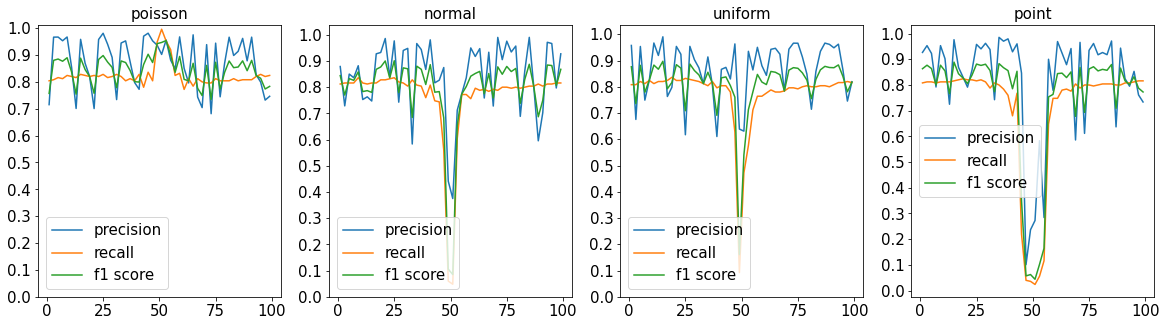

In [25]:
center_temp = 50
center_std = 5
total_time = 500

means = range(1, 100, 2)
distributions = [
    lambda x: np.random.poisson(x, total_time//2), 
    lambda x: np.random.normal(x, center_std, total_time//2),
    lambda x: np.random.uniform(x-(center_std**2 * 12)**0.5/2, x+(center_std**2 * 12)**0.5/2, total_time//2),
    lambda x: np.ones(total_time//2) * x
]
names = ["poisson", "normal", "uniform", "point"]
normal = lambda: np.random.normal(center_temp, center_std, total_time//2)

fig, ax = plt.subplots(1, 4, figsize=(20,5))
for idx, (name, distn) in enumerate(zip(names, distributions)):
    precision_arr = []
    recall_arr = []
    f1_arr = []
    for mean in tqdm(means):
        sensor_1 = np.concatenate([normal(), normal()])
        sensor_2 = np.concatenate([normal(), normal()])
        sensor_3 = np.concatenate([normal(), normal()])
        sensor_4 = np.concatenate([normal(), distn(mean)])
        dist_series = compute_anomalies_autoencoder([sensor_1, sensor_2, sensor_3, sensor_4], encoder, autoencoder, plot=False)
        correct = np.concatenate([np.zeros(total_time//2 - timesteps), np.ones(total_time//2)])
        (_, precision), (_, recall), (_, f1), _ = f1_score(correct, dist_series[:, 3])
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_arr.append(f1)

    ax[idx].plot(means, precision_arr, label="precision")
    ax[idx].plot(means, recall_arr, label="recall")
    ax[idx].plot(means, f1_arr, label="f1 score")
    ax[idx].legend(loc='best')
    ax[idx].set_title(name)
    ax[idx].set_yticks(np.arange(0, 1.1, 0.1))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.26it/s]


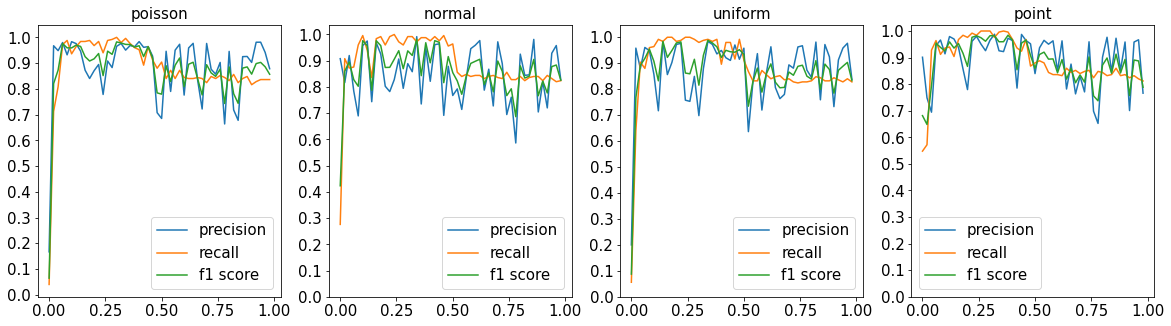

In [26]:
center_temp = 50
center_std = 5
total_time = 500
anomaly_mean = 40
probabilities = np.arange(0, 1, 0.02)
distributions = [
    lambda x: np.random.poisson(x, total_time//2), 
    lambda x: np.random.normal(x, center_std, total_time//2),
    lambda x: np.random.uniform(x-(center_std**2 * 12)**0.5/2, x+(center_std**2 * 12)**0.5/2, total_time//2),
    lambda x: np.ones(total_time//2) * x
]
names = ["poisson", "normal", "uniform", "point"]
normal = lambda: np.random.normal(center_temp, center_std, total_time//2)

fig, ax = plt.subplots(1, 4, figsize=(20,5))
for idx, (name, distn) in enumerate(zip(names, distributions)):
    precision_arr = []
    recall_arr = []
    f1_arr = []
    for prb in tqdm(probabilities):
        mask = np.random.choice([0, 1], total_time//2, p=[1-prb, prb])
        not_mask = np.logical_not(mask)
        anomalies = distn(20) * mask + normal() * not_mask
        sensor_1 = np.concatenate([normal(), normal()])
        sensor_2 = np.concatenate([normal(), normal()])
        sensor_3 = np.concatenate([normal(), normal()])
        sensor_4 = np.concatenate([normal(), anomalies])
        dist_series = compute_anomalies_autoencoder([sensor_1, sensor_2, sensor_3, sensor_4], encoder, autoencoder, plot=False)
        correct = np.concatenate([np.zeros(total_time//2 - timesteps), np.ones(total_time//2)])
        (_, precision), (_, recall), (_, f1), _ = f1_score(correct, dist_series[:, 3])
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_arr.append(f1)

    ax[idx].plot(probabilities, precision_arr, label="precision")
    ax[idx].plot(probabilities, recall_arr, label="recall")
    ax[idx].plot(probabilities, f1_arr, label="f1 score")
    ax[idx].legend(loc='best')
    ax[idx].set_title(name)
    ax[idx].set_yticks(np.arange(0, 1.1, 0.1))

# PCA

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.26it/s]


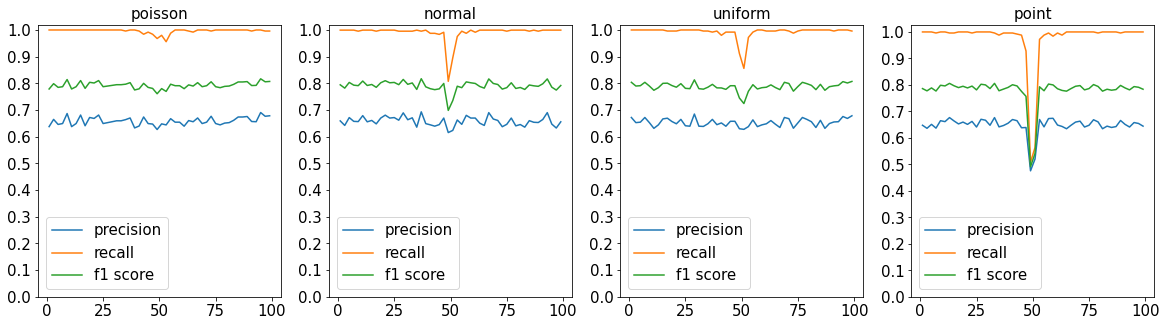

In [27]:
center_temp = 50
center_std = 5
total_time = 500

means = range(1, 100, 2)
distributions = [
    lambda x: np.random.poisson(x, total_time//2), 
    lambda x: np.random.normal(x, center_std, total_time//2),
    lambda x: np.random.uniform(x-(center_std**2 * 12)**0.5/2, x+(center_std**2 * 12)**0.5/2, total_time//2),
    lambda x: np.ones(total_time//2) * x
]
names = ["poisson", "normal", "uniform", "point"]
normal = lambda: np.random.normal(center_temp, center_std, total_time//2)

fig, ax = plt.subplots(1, 4, figsize=(20,5))
for idx, (name, distn) in enumerate(zip(names, distributions)):
    precision_arr = []
    recall_arr = []
    f1_arr = []
    for mean in tqdm(means):
        sensor_1 = np.concatenate([normal(), normal()])
        sensor_2 = np.concatenate([normal(), normal()])
        sensor_3 = np.concatenate([normal(), normal()])
        sensor_4 = np.concatenate([normal(), distn(mean)])
        dist_series = compute_anomalies_pca([sensor_1, sensor_2, sensor_3, sensor_4], pca, plot=False)
        correct = np.concatenate([np.zeros(total_time//2 - timesteps), np.ones(total_time//2)])
        (_, precision), (_, recall), (_, f1), _ = f1_score(correct, dist_series[:, 3])
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_arr.append(f1)

    ax[idx].plot(means, precision_arr, label="precision")
    ax[idx].plot(means, recall_arr, label="recall")
    ax[idx].plot(means, f1_arr, label="f1 score")
    ax[idx].legend(loc='best')
    ax[idx].set_title(name)
    ax[idx].set_yticks(np.arange(0, 1.1, 0.1))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.57it/s]


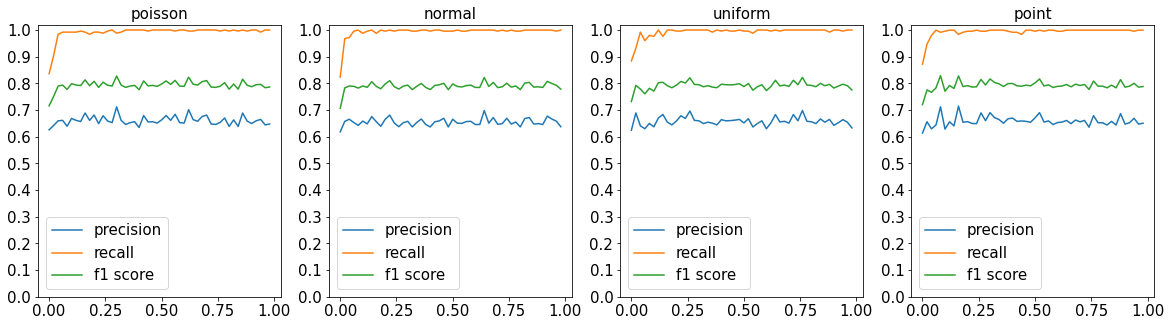

In [28]:
center_temp = 50
center_std = 5
total_time = 500
anomaly_mean = 40

probabilities = np.arange(0, 1, 0.02)
distributions = [
    lambda x: np.random.poisson(x, total_time//2), 
    lambda x: np.random.normal(x, center_std, total_time//2),
    lambda x: np.random.uniform(x-(center_std**2 * 12)**0.5/2, x+(center_std**2 * 12)**0.5/2, total_time//2),
    lambda x: np.ones(total_time//2) * x
]
names = ["poisson", "normal", "uniform", "point"]
normal = lambda: np.random.normal(center_temp, center_std, total_time//2)

fig, ax = plt.subplots(1, 4, figsize=(20,5))
for idx, (name, distn) in enumerate(zip(names, distributions)):
    precision_arr = []
    recall_arr = []
    f1_arr = []
    for prb in tqdm(probabilities):
        mask = np.random.choice([0, 1], total_time//2, p=[1-prb, prb])
        not_mask = np.logical_not(mask)
        anomalies = distn(20) * mask + normal() * not_mask
        sensor_1 = np.concatenate([normal(), normal()])
        sensor_2 = np.concatenate([normal(), normal()])
        sensor_3 = np.concatenate([normal(), normal()])
        sensor_4 = np.concatenate([normal(), anomalies])
        dist_series = compute_anomalies_pca([sensor_1, sensor_2, sensor_3, sensor_4], pca, plot=False)
        correct = np.concatenate([np.zeros(total_time//2 - timesteps), np.ones(total_time//2)])
        (_, precision), (_, recall), (_, f1), _ = f1_score(correct, dist_series[:, 3])
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_arr.append(f1)

    ax[idx].plot(probabilities, precision_arr, label="precision")
    ax[idx].plot(probabilities, recall_arr, label="recall")
    ax[idx].plot(probabilities, f1_arr, label="f1 score")
    ax[idx].legend(loc='best')
    ax[idx].set_title(name)
    ax[idx].set_yticks(np.arange(0, 1.1, 0.1))

In [43]:
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
Total params: 17,936
Trainable params: 17,936
Non-trainable params: 0
_________________________________________________________________


In [8]:
# layers * timesteps * 8 * 2 * hiddenSize * minibatch * (hiddenSize + 1)
# = 2*100*8*2*64*65
# approx 13 million flops

In [9]:
# pca is matrix multiplication of a 1x100 vector and 100x16 vector, so approx 1600 flops

In [10]:
%%timeit
with tf.device("/cpu:0"):
    encoder.predict(np.zeros((1,100)))

27.8 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
pca.predict(np.zeros((1,100)))

32 µs ± 295 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%%timeit
with tf.device("/cpu:0"):
    encoder.predict(np.zeros((1,100)))

27.2 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Select Encoder

In [13]:
from sklearn.decomposition import FastICA, TruncatedSVD, PCA, FactorAnalysis

class Pca:
    def __init__(self, data):
        self.model = PCA(16).fit(data)
    def predict(self, data):
        return self.model.transform(data)

class FactorAnal:
    def __init__(self, data):
        self.model = FactorAnalysis(32).fit(data)
    def predict(self, data):
        return self.model.transform(data)

class ICA:
    def __init__(self, data):
        self.model = FastICA(n_components=16, random_state=12).fit(data)
    def predict(self, data):
        return self.model.transform(data)
    
pca = Pca(data.reshape((100000, 100)))
# encoder = FactorAnal(data.reshape((100000, 100)))
# encoder = ICA(data.reshape((100000, 100)))

In [14]:
center_temp = 50
center_std = 2
total_time = 150
deltas = np.arange(0,100,2)
autoencoder_dists = np.zeros((50))
pca_dists = np.zeros((50))
for idx, delta_t in enumerate(tqdm(range(0, 100, 2))):
    sensor_1 = np.random.normal(center_temp + delta_t, center_std, total_time)
    sensor_2 = np.random.normal(center_temp, center_std, total_time)
    sensor_array = np.vstack([sensor_1, sensor_2])
    sensor_autoencoder = np.zeros((50))
    sensor_pca = np.zeros((50))
    for i in range(50):
        truncated_timeseries = sensor_array[:, i:i+100]
        truncated_autoencodings = encoder.predict(truncated_timeseries)
        truncated_pca = pca.predict(truncated_timeseries)
        sensor_autoencoder[i] = distance_matrix(truncated_autoencodings, truncated_autoencodings)[0][1]
        sensor_pca[i] = distance_matrix(truncated_pca, truncated_pca)[0][1]
    autoencoder_dists[idx] = np.mean(sensor_autoencoder)
    pca_dists[idx] = np.mean(sensor_pca)

NameError: name 'tqdm' is not defined

In [43]:
deltas

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98])

In [44]:
autoencoder_dists

array([ 0.23226241,  0.4720696 ,  0.90759435,  1.28998234,  1.81762452,
        2.2984505 ,  2.63470838,  3.16870278,  3.68440298,  4.21441826,
        4.73280016,  5.39254948,  6.11851736,  6.80325983,  7.4411504 ,
        8.07481104,  8.61772647, 10.44817179, 12.47123301, 15.75572365,
       17.53045806, 20.5348661 , 21.47422587, 21.71835885, 21.74737298,
       21.79386092, 21.65998715, 21.69079167, 21.70106808, 21.55514767,
       21.55217609, 21.53691322, 21.32650677, 20.84576812, 20.33138739,
       20.1282548 , 19.97290762, 19.97191679, 19.95103915, 19.8739518 ,
       19.81675385, 19.78695659, 19.7760183 , 19.78026541, 19.73864932,
       19.67975034, 19.60820935, 19.5628757 , 19.51324663, 19.54347196])

In [45]:
pca_dists

array([ 10.07476338,  23.08466064,  39.1073746 ,  62.94652147,
        80.34625086, 105.57278336, 119.87926762, 138.6225276 ,
       162.52549517, 182.67446397, 198.80910413, 216.62617737,
       240.81799967, 257.87933586, 278.9515943 , 304.66123664,
       317.9036968 , 339.55118121, 360.57692431, 383.65368905,
       402.91935627, 421.65134291, 442.82251582, 457.10641094,
       478.74074127, 497.14421064, 523.65550003, 540.44313779,
       561.40088501, 576.17736879, 597.4944817 , 621.32434447,
       641.77096217, 655.90474086, 679.38020812, 702.0927946 ,
       723.27880269, 738.23063016, 758.87498855, 778.36955268,
       800.13297739, 820.52118837, 841.97888071, 859.52107996,
       880.43290596, 899.88942832, 920.22509944, 940.40969131,
       956.97987292, 983.11501023])

In [1]:
plt.plot(deltas, autoencoder_dists, color="blue")
plt.plot(deltas, pca_dists, color="orange")
plt.yscale("log")
plt.ylabel("Distance Difference")
plt.xlabel("Difference in Means")

NameError: name 'plt' is not defined

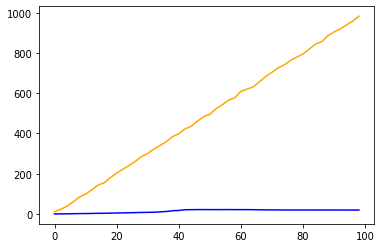

In [28]:
plt.plot(deltas, autoencoder_dists, color="blue")
plt.plot(deltas, pca_dists, color="orange")
# plt.yscale("log")

 29%|██████████████████████▏                                                      | 549/1900 [00:00<00:00, 5484.72it/s]

10.951272449921378
15.929758599634182
9.737545967204019
10.843584186249577
14.316320273999843
15.663843117265573
12.531495675737638
12.747836984059633
16.837729176239208
12.916253877547973
15.757999435907225
14.077417376885041
13.60179324774872
12.068037700037204
12.962322484211754
14.354801852970066
14.076525563848506
10.879047882656533
12.401600673731513
11.115189769774034
15.479497061628159
11.248288498477926
10.294888884685903
13.529558449419278
11.892013148823773
9.591052579144247
12.874784249245556
15.348521196350363
13.581013793622017
11.210380140422973
13.884860549061477
12.760428502665345
12.273708758600884
11.590596038204486
12.888789905734097
11.36847846756587
12.073823246258128
10.961203007400275
11.511680305571401
13.151594938001935
10.222438007944447
12.841213668137188
11.177600603668393
13.057251047412201
12.593552778507107
10.7395261295367
11.20260296443485
14.388253704912016
8.312274646162162
11.772246492239994
16.085294292484917
15.763523741175907
13.9554947506978
12.

100%|████████████████████████████████████████████████████████████████████████████| 1900/1900 [00:00<00:00, 5550.47it/s]

32.354882330414895
31.948403286213484
31.465029220281767
32.238071208067055
31.963467143520457
32.60555540994414
33.17731594301225
32.69192298448402
33.8822613911742
31.736019347765097
33.94636574526942
31.90357254901318
32.65177174430226
32.539910049833026
33.28342894660149
33.67402310330704
32.59792774762379
34.54610094534563
32.66283970701116
32.72150014942787
31.114669184856105
31.65849270807911
30.785035239430226
32.496766115293624
31.472898860452776
30.9270647995282
31.17919936606446
32.04278935435099
31.4346630612548
32.45118405595793
31.40035792492021
31.67211973516838
31.930102469481916
32.14650971338983
31.895731558087522
31.987193458364278
32.46562128940522
31.448114188383162
31.722033375672147
31.915461072400767
32.40484319140447
31.719101624379412
31.194259692114727
32.36681354389791
33.617935775861305
32.15902025419801
31.289924877431474
31.779488965442965
32.71866049380065
33.35085490931296
34.132627168662474
32.06196965626444
31.937953439449263
32.14923370479822
31.6626

Text(0.5, 0.91, 'Difference in Means: 3')

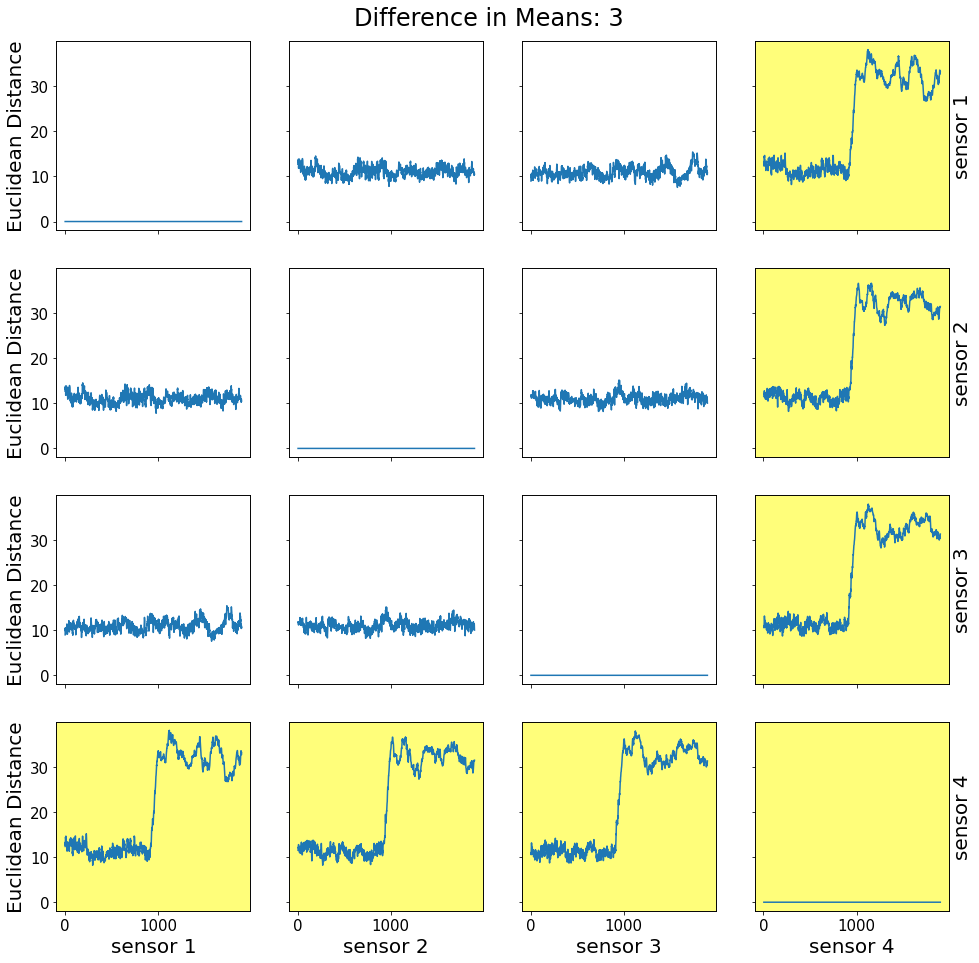

In [105]:
# Test 1

center_temp = 10
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(13, center_std, total_time//2)])
dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], pca)
fig.suptitle("Difference in Means: 3", y=.91)

100%|███████████████████████████████████████████████████████████████████████████| 1900/1900 [00:00<00:00, 17985.38it/s]


8.305762718942896 5.0763900994642555


Text(0.5, 0.91, 'Difference in Means: 40')

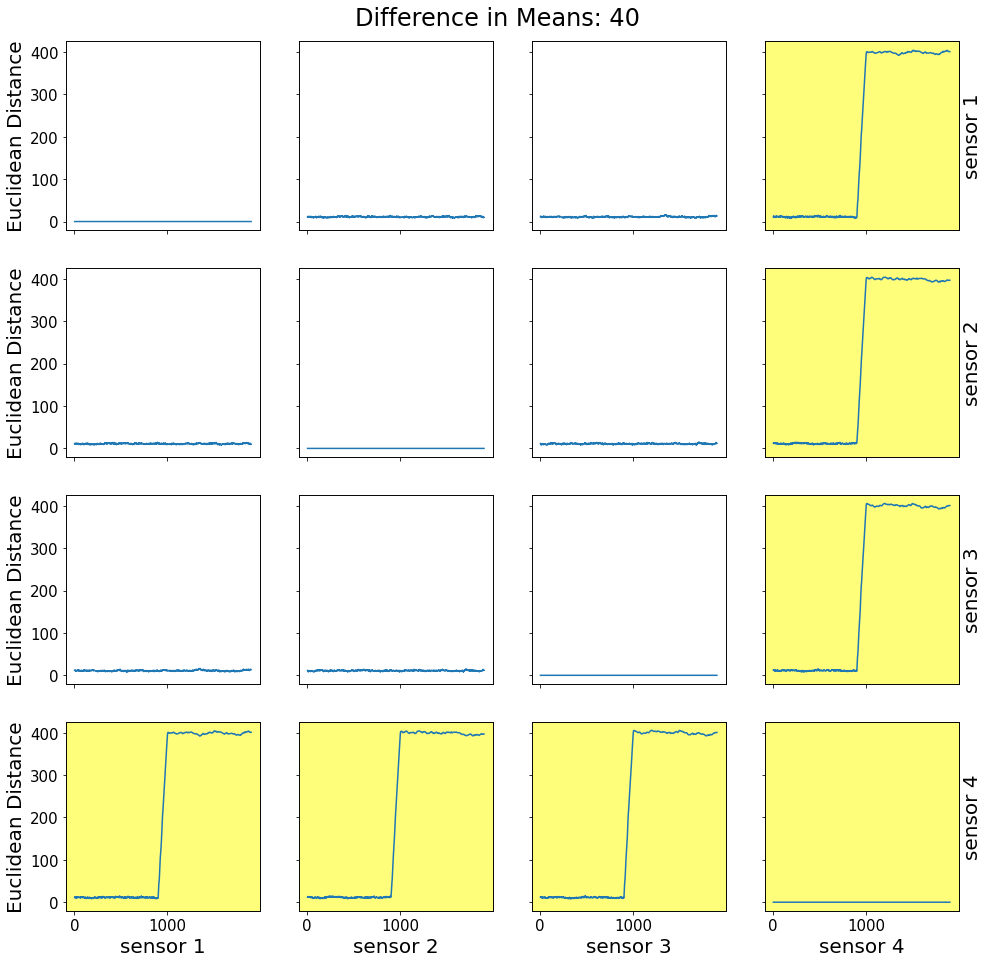

In [77]:
# Test 4

center_temp = 60
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(100, 2, total_time//2)])
dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], pca)
print(np.mean(dist_series[:800]), np.std(dist_series[:800]))
fig.suptitle("Difference in Means: 40", y=.91)

100%|███████████████████████████████████████████████████████████████████████████| 1900/1900 [00:00<00:00, 16184.72it/s]


8.262859275908875 5.067352795299604


Text(0.5, 0.91, 'Erasure Rate: 5%')

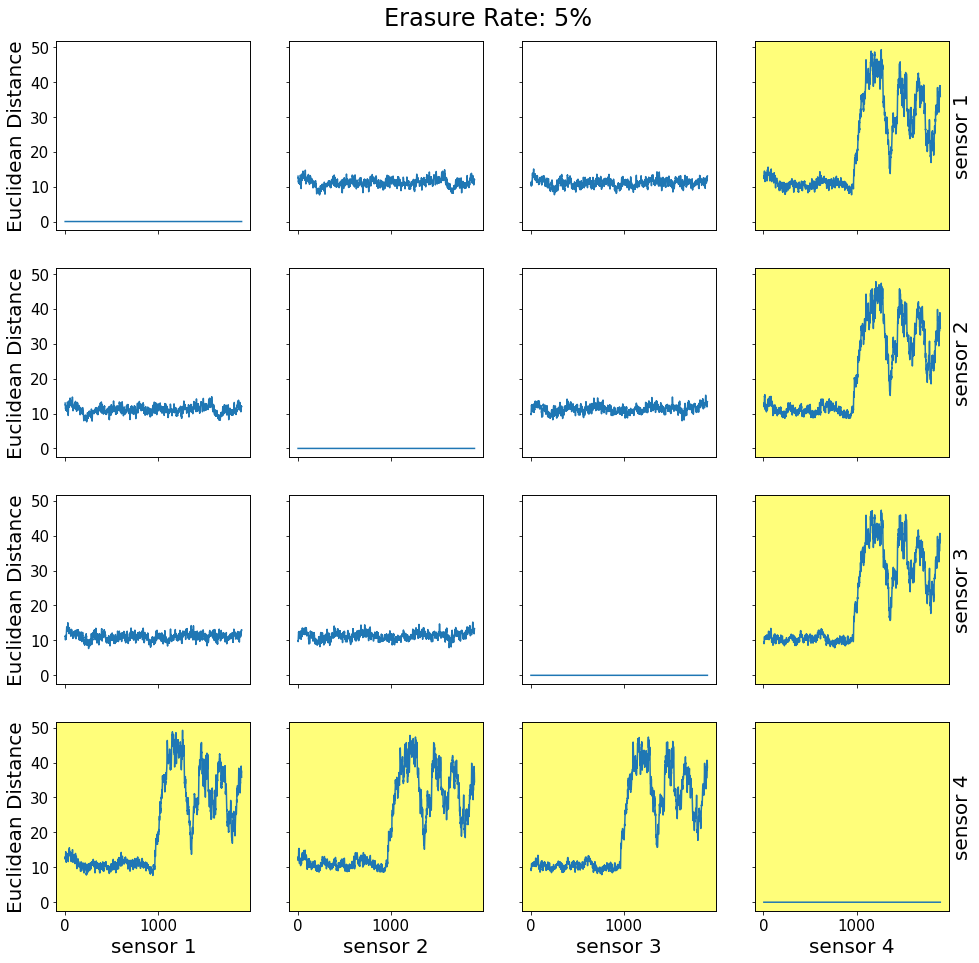

In [73]:
# Erasure Noise

center_temp = 30
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])

mask_4 = np.random.choice([0, 1], 1000, p=[0.05, 0.95])
mask_4 = np.concatenate([np.ones((1000,)), mask_4])
sensor_4 = np.multiply(sensor_4, mask_4)

dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], pca)
print(np.mean(dist_series[:800]), np.std(dist_series[:800]))
fig.suptitle("Erasure Rate: 5%", y=.91)

100%|███████████████████████████████████████████████████████████████████████████| 1900/1900 [00:00<00:00, 16796.13it/s]


8.395650186869348 5.139049113222105


Text(0.5, 0.91, 'Erasure Rate: 20%')

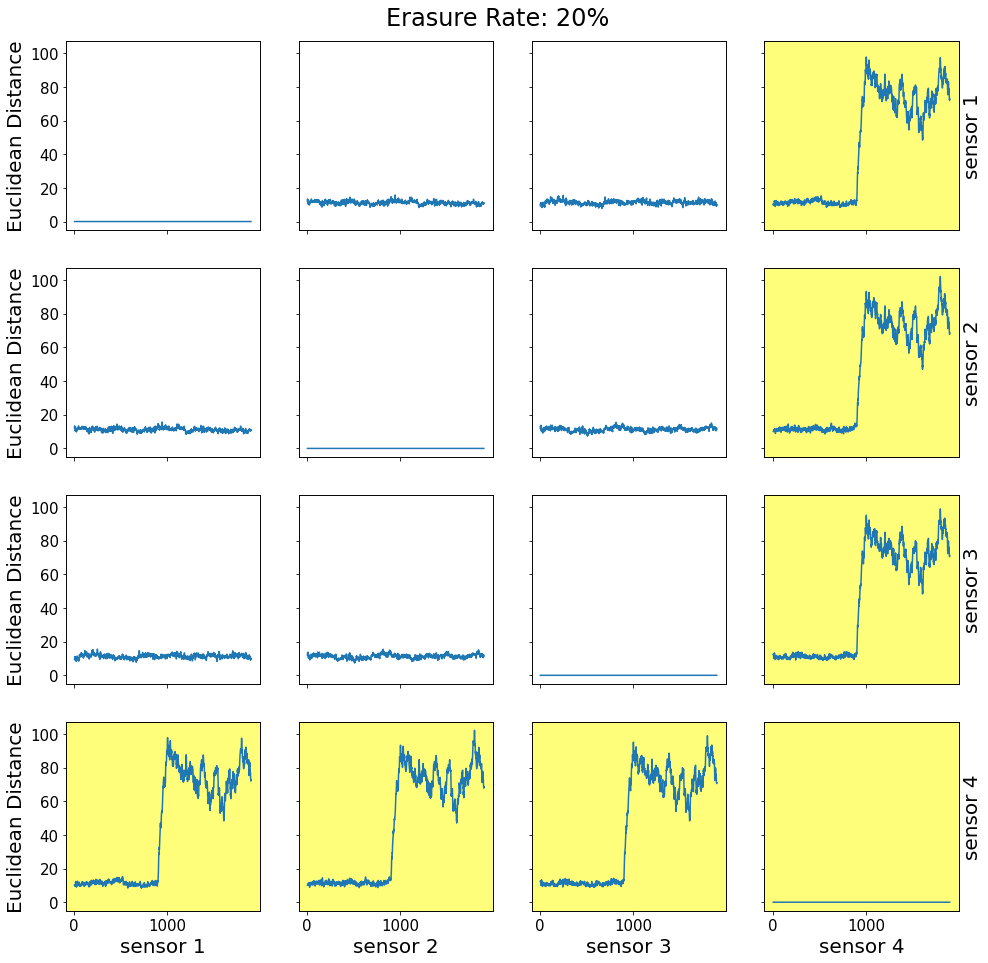

In [74]:
# Erasure Noise

center_temp = 30
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])

mask_4 = np.random.choice([0, 1], 1000, p=[0.2, 0.8])
mask_4 = np.concatenate([np.ones((1000,)), mask_4])
sensor_4 = np.multiply(sensor_4, mask_4)

dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], pca)
print(np.mean(dist_series[:800]), np.std(dist_series[:800]))
fig.suptitle("Erasure Rate: 20%", y=.91)

100%|███████████████████████████████████████████████████████████████████████████| 1900/1900 [00:00<00:00, 16311.40it/s]


8.183940887260878 5.002551868445608


Text(0.5, 0.91, 'Difference in Mean: 15, Erasure Rate: 10%')

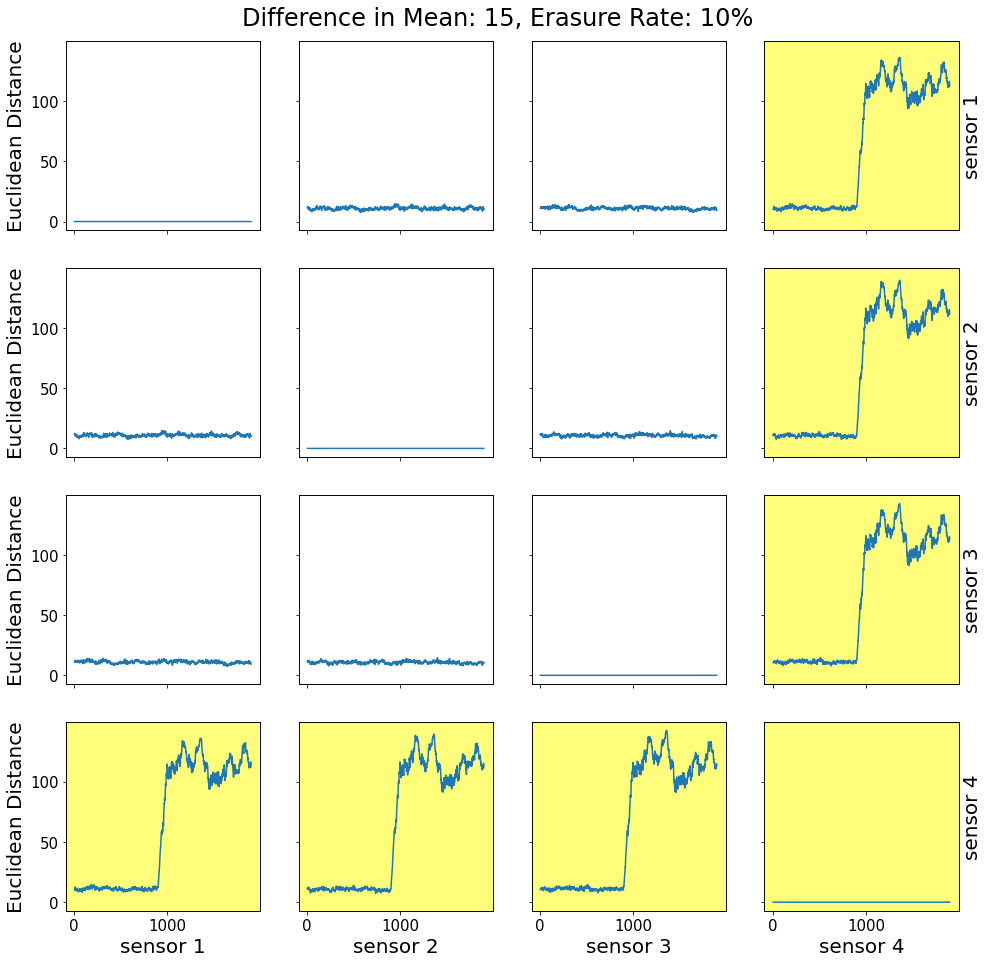

In [75]:
# Erasure Noise

center_temp = 30
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(45, center_std, total_time//2)])

mask_4 = np.random.choice([0, 1], 1000, p=[0.1, 0.9])
mask_4 = np.concatenate([np.ones((1000,)), mask_4])
sensor_4 = np.multiply(sensor_4, mask_4)

dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], pca)
print(np.mean(dist_series[:800]), np.std(dist_series[:800]))
fig.suptitle("Difference in Mean: 15, Erasure Rate: 10%", y=.91)

# Auto Encoder

100%|██████████████████████████████████████████████████████████████████████████████| 1900/1900 [01:11<00:00, 26.54it/s]


0.16966813817735343 0.13993673868552228


Text(0.5, 0.91, 'Difference in Mean: 3')

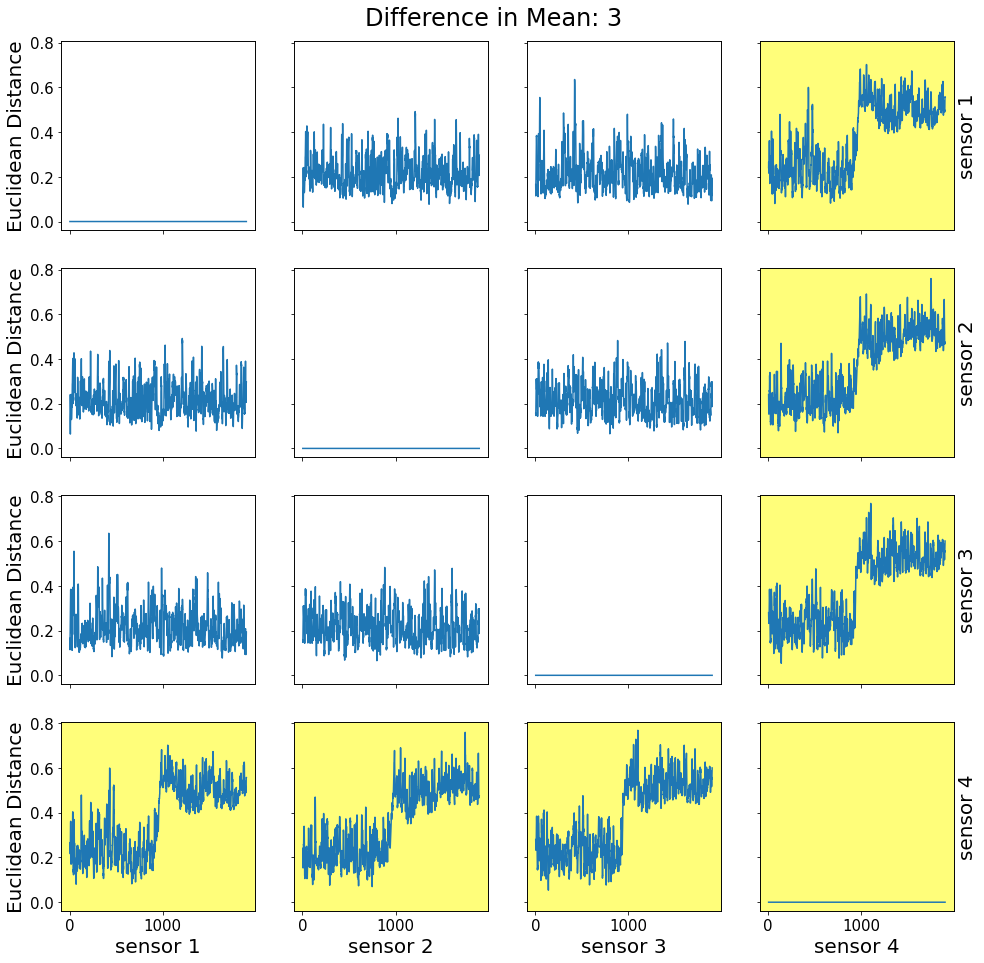

In [76]:
# Test 3

center_temp = 10
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(13, center_std, total_time//2)])
dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], encoder)

print(np.mean(dist_series[:800]), np.std(dist_series[:800]))
fig.suptitle("Difference in Mean: 3", y=.91)

100%|██████████████████████████████████████████████████████████████████████████████| 1900/1900 [01:10<00:00, 26.88it/s]


0.19395236503059501 0.18155062086103524


Text(0.5, 0.91, 'Difference in Mean: 40')

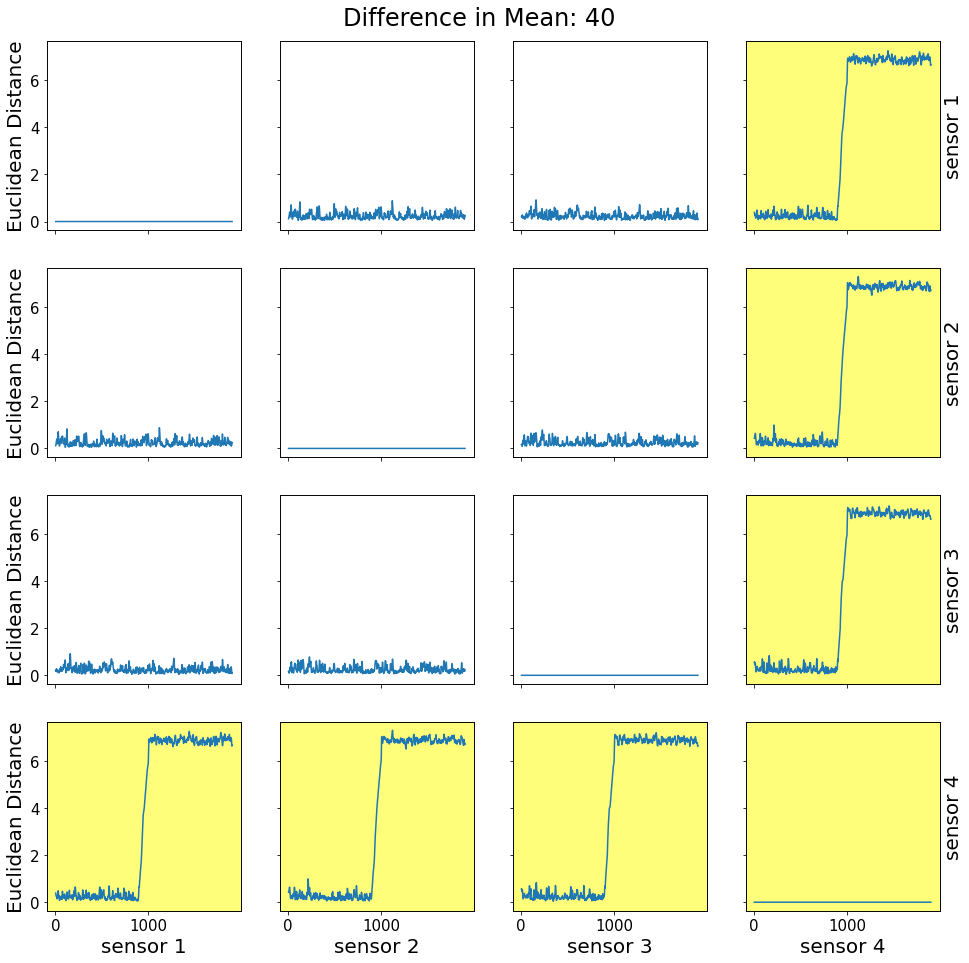

In [77]:
# Test 4

center_temp = 60
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(20, center_std, total_time//2)])
dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], encoder)
print(np.mean(dist_series[:800]), np.std(dist_series[:800]))
fig.suptitle("Difference in Mean: 40", y=.91)

100%|██████████████████████████████████████████████████████████████████████████████| 1900/1900 [01:08<00:00, 27.67it/s]


0.15812231486644537 0.13901863924300148


Text(0.5, 0.91, 'Erasure Rate: 5%')

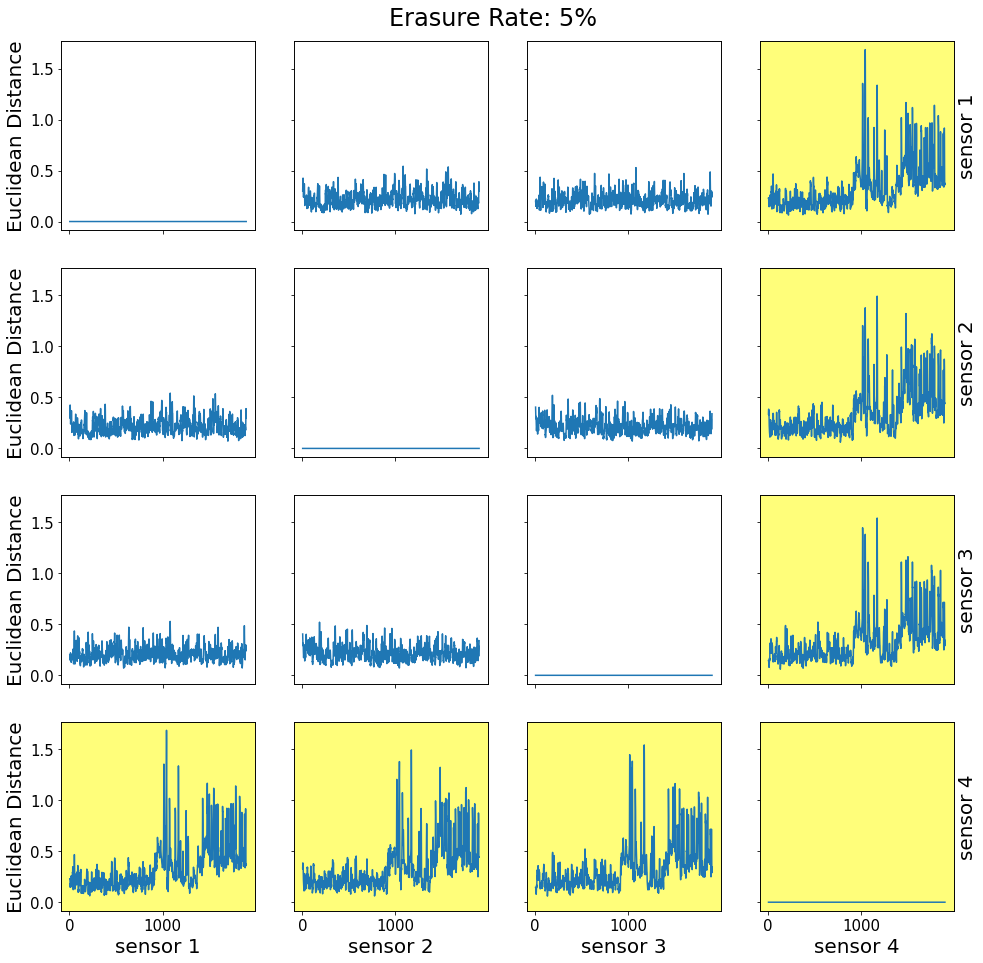

In [78]:
# Erasure Noise

center_temp = 30
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])

mask_4 = np.random.choice([0, 1], 1000, p=[0.05, 0.95])
mask_4 = np.concatenate([np.ones((1000,)), mask_4])
sensor_4 = np.multiply(sensor_4, mask_4)

dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], encoder)
print(np.mean(dist_series[:800]), np.std(dist_series[:800]))
fig.suptitle("Erasure Rate: 5%", y=.91)

100%|██████████████████████████████████████████████████████████████████████████████| 1900/1900 [01:06<00:00, 28.38it/s]


0.16600874511111993 0.14268211580310064


Text(0.5, 0.91, 'Erasure Rate: 20%')

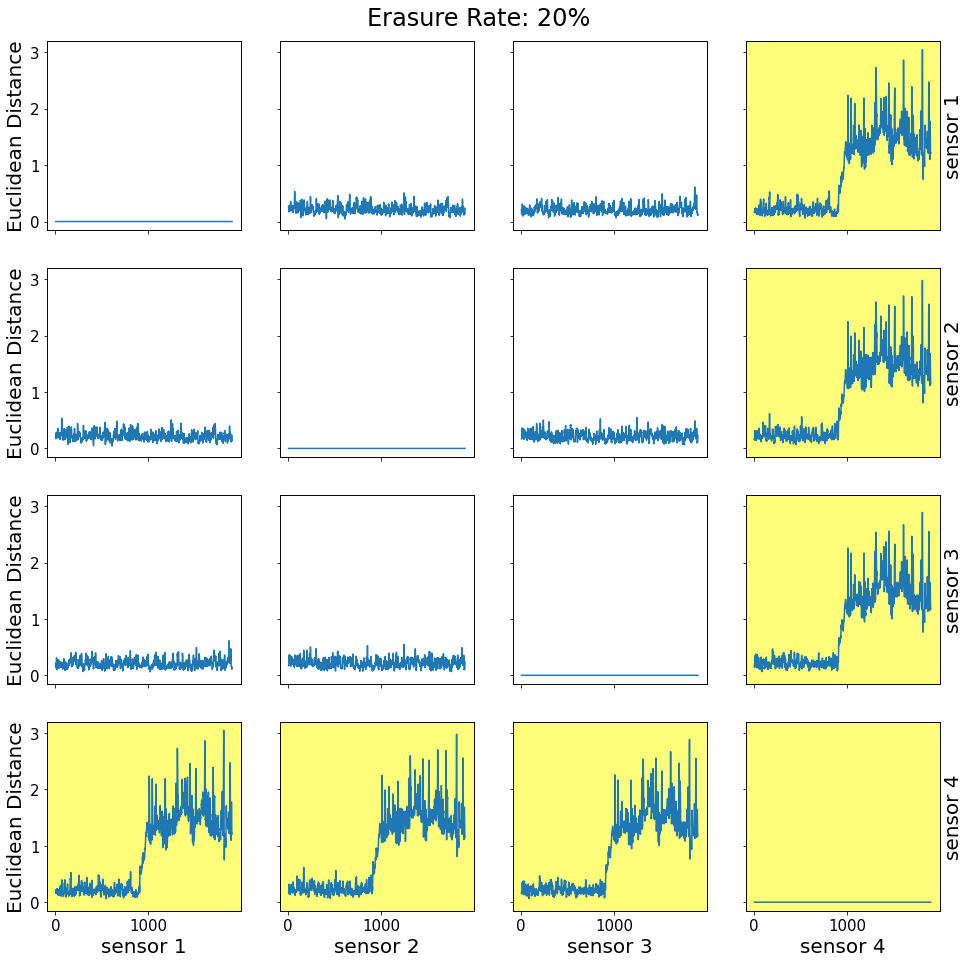

In [79]:
# Erasure Noise

center_temp = 30
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])

mask_4 = np.random.choice([0, 1], 1000, p=[0.2, 0.8])
mask_4 = np.concatenate([np.ones((1000,)), mask_4])
sensor_4 = np.multiply(sensor_4, mask_4)

dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], encoder)
print(np.mean(dist_series[:800]), np.std(dist_series[:800]))
fig.suptitle("Erasure Rate: 20%", y=.91)

100%|██████████████████████████████████████████████████████████████████████████████| 1900/1900 [01:06<00:00, 28.44it/s]


0.16041269053147622 0.1395411383754552


Text(0.5, 0.91, 'Difference in Mean: 15, Erasure Rate: 10%')

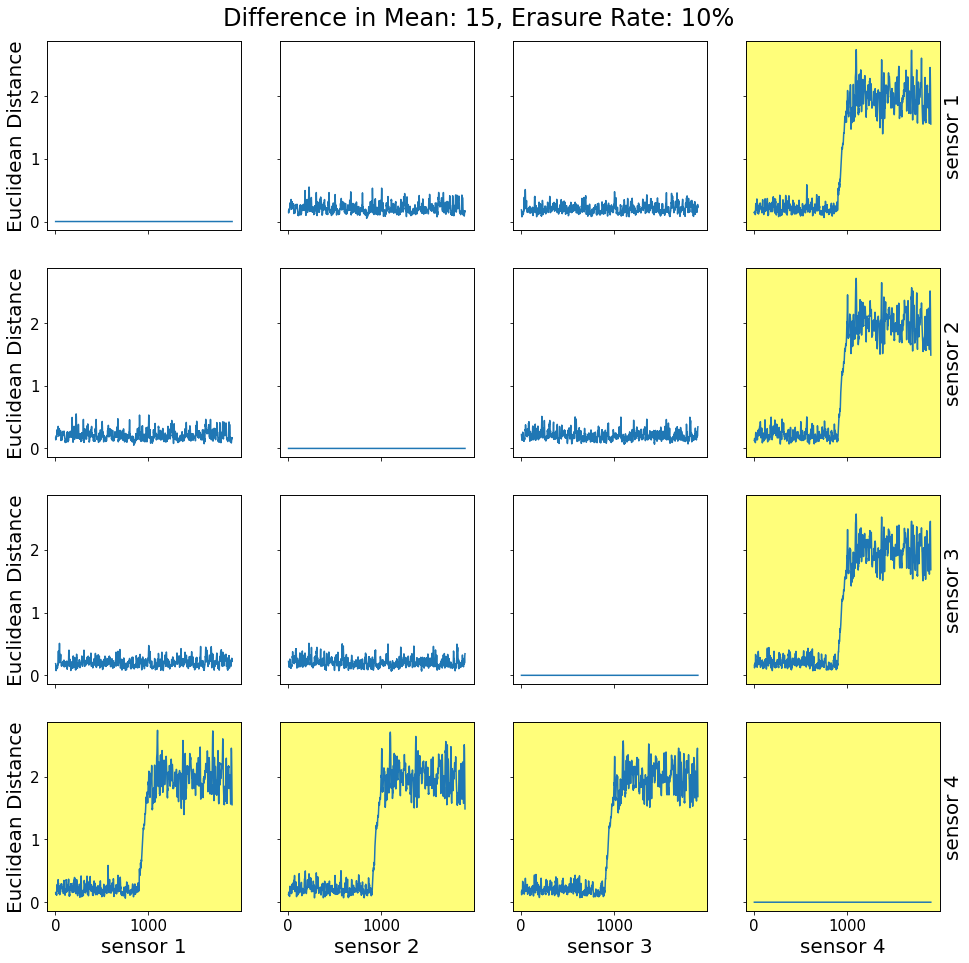

In [80]:
# Erasure Noise

center_temp = 30
center_std = 2
total_time = 2000
sensor_1 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_2 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_3 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(center_temp, center_std, total_time//2)])
sensor_4 = np.concatenate([np.random.normal(center_temp, center_std, total_time//2), np.random.normal(45, center_std, total_time//2)])

mask_4 = np.random.choice([0, 1], 1000, p=[0.1, 0.9])
mask_4 = np.concatenate([np.ones((1000,)), mask_4])
sensor_4 = np.multiply(sensor_4, mask_4)

dist_series, fig = compute_distances([sensor_1, sensor_2, sensor_3, sensor_4], encoder)
print(np.mean(dist_series[:800]), np.std(dist_series[:800]))
fig.suptitle("Difference in Mean: 15, Erasure Rate: 10%", y=.91)